# 具有神经网络思维的Logistic回归

参照：https://blog.csdn.net/u013733326/article/details/79639509

介绍：搭建一个能够“识别猫”的简易神经网络

在开始之前，我们需要引入如下的库
 - numpy：Python进行科学计算的基本软件包
 - h5py：与H5文件种存储的数据集进行交互的常用软件包
 - matplotlib：一个著名的库，用于在Python种绘制图表
 - lr_utils：文本资料包里，用来加载数据包里数据的文件

## 1 - 前期数据准备

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lr_utils import load_dataset

`lr_utils.py`文件如下

In [3]:
import numpy as np
import h5py
    
    
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

`load_dataset()`返回值的含义如下：
 - train_set_x_orig：保存的是训练集里面的图像数据（本训练集有209张64x64的图像）
 - train_set_y_orig：保存的是训练集的图像对应的分类值（[0 | 1]，0表示不是猫，1表示是猫）
 - test_set_x_orig：保存的是测试集里面的图像数据（本训练集有50张64x64的图像）
 - test_set_y_orig：保存的是测试集的图像对应的分类值（[0 | 1]，0表示不是猫，1表示是猫）
 - classes：保存的是以bytes类型保存的两个字符串数据，数据为：[b'non-cat' b'cat']

现在就让我们来加载这些数据到主程序里面

In [4]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = load_dataset()

我们可以看一下我们加载的文件里面的图片都是些说明样子，比如查看训练集第26张图片

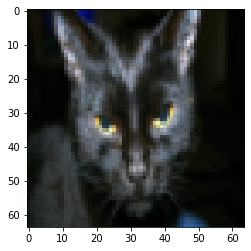

In [5]:
index = 25
plt.imshow(train_set_x_orig[index])

可以结合一下训练集里的数据来看我们都加载了一些什么数据

In [6]:
#使用np.squeeze的目的是压缩维度，【未压缩】train_set_y[:,index]的值为[1] , 【压缩后】np.squeeze(train_set_y[:,index])的值为1
#print("【使用np.squeeze：" + str(np.squeeze(train_set_y[:,index])) + "，不使用np.squeeze： " + str(train_set_y[:,index]) + "】")
#只有压缩后的值才能进行解码操作
print("y=" + str(train_set_y[:,index]) + ", it's a " + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") + "' picture")

y=[1], it's a cat' picture


In [12]:
m_train = train_set_y.shape[1] #训练集里图片的数量。
m_test = test_set_y.shape[1] #测试集里图片的数量。
num_px = train_set_x_orig.shape[1] #训练、测试集里面的图片的宽度和高度（均为64x64）。

#现在看一看我们加载的东西的具体情况
print ("训练集的数量: m_train = " + str(m_train))
print ("测试集的数量 : m_test = " + str(m_test))
print ("每张图片的宽/高 : num_px = " + str(num_px))
print ("每张图片的大小 : (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("训练集_图片的维数 : " + str(train_set_x_orig.shape))
print ("训练集_标签的维数 : " + str(train_set_y.shape))
print ("测试集_图片的维数: " + str(test_set_x_orig.shape))
print ("测试集_标签的维数: " + str(test_set_y.shape))

训练集的数量: m_train = 209
测试集的数量 : m_test = 50
每张图片的宽/高 : num_px = 64
每张图片的大小 : (64, 64, 3)
训练集_图片的维数 : (209, 64, 64, 3)
训练集_标签的维数 : (1, 209)
测试集_图片的维数: (50, 64, 64, 3)
测试集_标签的维数: (1, 50)


## 2 - 数据预处理

为了方便，我们要把维度为(64,64,3)的numpy数组重新构造为(64 * 64 * 64 * 3,1)的数组，每张图片由64 * 64像素构成，而每个像素点又由（R,G,B）三原色构成。在此之后，我们的训练和测试数据集是一个numpy数组，每列代表一个平坦的图像

当想将形状（a,b,c,d）的矩阵X平铺成形状（b * c * d,a）的矩阵X_flatten时，可以使用如下代码

In [8]:
#X_flatten = X.reshape(X.shape [0]，-1).T ＃X.T是X的转置
#将训练集的维度降低并转置。
train_set_x_flatten  = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
#将测试集的维度降低并转置。
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

上面将第一行命令，将数组变为209行的矩阵（训练集有209张图片），列直接用-1表示，让程序自动去计算。最后用T转置

降维之后的情况如下

In [9]:
print ("训练集降维最后的维度： " + str(train_set_x_flatten.shape))
print ("训练集_标签的维数 : " + str(train_set_y.shape))
print ("测试集降维之后的维度: " + str(test_set_x_flatten.shape))
print ("测试集_标签的维数 : " + str(test_set_y.shape))

训练集降维最后的维度： (12288, 209)
训练集_标签的维数 : (1, 209)
测试集降维之后的维度: (12288, 50)
测试集_标签的维数 : (1, 50)


对数据做标准化，对于图片数据集，将数据集的每一行除以255，就可以让标准化的数据位于[0,1]之间

In [13]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

## 3 - 网络结构说明

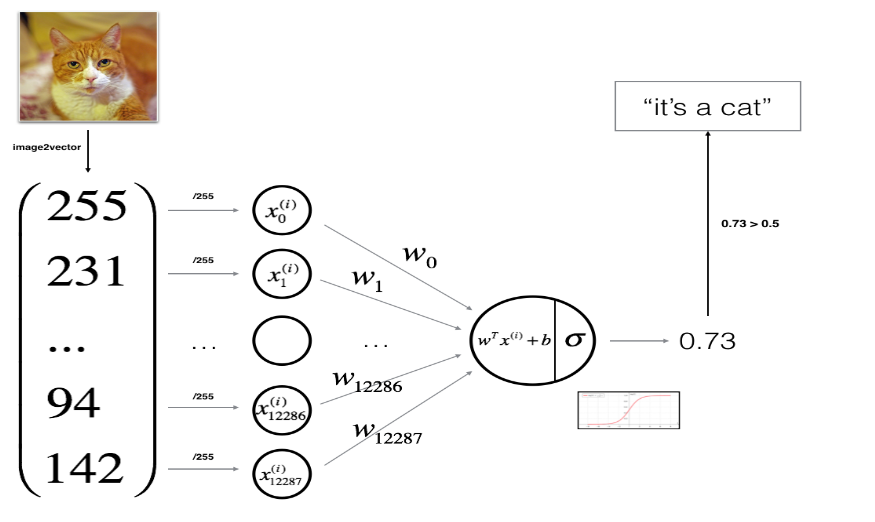

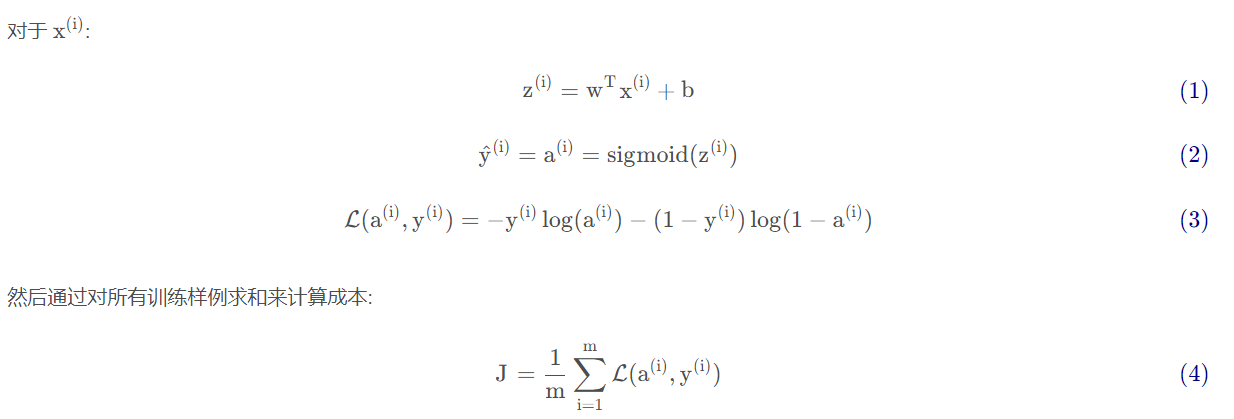

建立神经网络的主要步骤如下：
 - 定义模型结构
 - 初始化模型的参数
 - 循环
  - 计算当前损失（正向传播）
  - 计算当前梯度（反向传播）
  - 更新参数（梯度下降）

##  4 - 神经网络的代码编写

### 4.1 选取激活函数

In [16]:
def sigmoid(z):
    """
    参数：
        z  - 任何大小的标量或numpy数组。

    返回：
        s  -  sigmoid（z）
    """
    s = 1 / (1 + np.exp(-z))
    return s

In [17]:
print("====================测试sigmoid====================")
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

====================测试sigmoid====================
sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


### 4.2 初始化参数

In [15]:
def initialize_with_zeros(dim):
    """
        此函数为w创建一个维度为（dim，1）的0向量，并将b初始化为0。

        参数：
            dim  - 我们想要的w矢量的大小（或者这种情况下的参数数量）

        返回：
            w  - 维度为（dim，1）的初始化向量。
            b  - 初始化的标量（对应于偏差）
    """
    w = np.zeros(shape=(dim, 1))
    b = 0
    # 使用断言来确保我要的数据是正确的
    assert (w.shape == (dim, 1))  # w的维度是(dim,1)
    assert (isinstance(b, float) or isinstance(b, int))  # b的类型是float或者是int

    return (w, b)

### 4.3 前向、反向传播的渐变函数

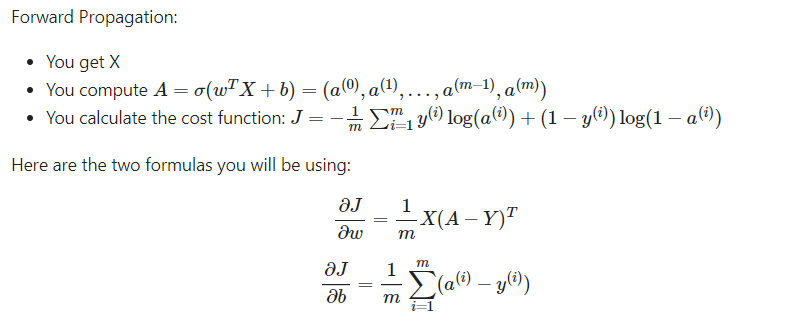

In [18]:
def propagate(w, b, X, Y):
    """
    实现前向和后向传播的成本函数及其梯度。
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 矩阵类型为（num_px * num_px * 3，训练数量）
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据数量)

    返回：
        cost- 逻辑回归的负对数似然成本
        dw  - 相对于w的损失梯度，因此与w相同的形状
        db  - 相对于b的损失梯度，因此与b的形状相同
    """
    m = X.shape[1]

    # 正向传播
    A = sigmoid(np.dot(w.T, X) + b)  # 计算激活值，请参考公式2。
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # 计算成本，请参考公式3和4。

    # 反向传播
    dw = (1 / m) * np.dot(X, (A - Y).T)  # 请参考视频中的偏导公式。
    db = (1 / m) * np.sum(A - Y)  # 请参考视频中的偏导公式。

    # 使用断言确保我的数据是正确的
    assert (dw.shape == w.shape)
    assert (db.dtype == float)
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    # 创建一个字典，把dw和db保存起来。
    grads = {
        "dw": dw,
        "db": db
    }
    return (grads, cost)

In [19]:
#测试一下propagate
print("====================测试propagate====================")
#初始化一些参数
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

====================测试propagate====================
dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


In [20]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    此函数通过运行梯度下降算法来优化w和b

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数组。
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据的数量)
        num_iterations  - 优化循环的迭代次数
        learning_rate  - 梯度下降更新规则的学习率
        print_cost  - 每100步打印一次损失值

    返回：
        params  - 包含权重w和偏差b的字典
        grads  - 包含权重和偏差相对于成本函数的梯度的字典
        成本 - 优化期间计算的所有成本列表，将用于绘制学习曲线。

    提示：
    我们需要写下两个步骤并遍历它们：
        1）计算当前参数的成本和梯度，使用propagate（）。
        2）使用w和b的梯度下降法则更新参数。
    """

    costs = []

    for i in range(num_iterations):

        grads, cost = propagate(w, b, X, Y)

        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw
        b = b - learning_rate * db

        # 记录成本
        if i % 100 == 0:
            costs.append(cost)
        # 打印成本数据
        if (print_cost) and (i % 100 == 0):
            print("迭代的次数: %i ， 误差值： %f" % (i, cost))

    params = {
        "w": w,
        "b": b}
    grads = {
        "dw": dw,
        "db": db}
    return (params, grads, costs)

In [22]:
#测试optimize
print("====================测试optimize====================")
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
params , grads , costs = optimize(w , b , X , Y , num_iterations=100 , learning_rate = 0.009 , print_cost = False)
print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

====================测试optimize====================
w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


### 4.4 预测函数

现在optimize函数会输出已学习的w和b的值，我们可以使用w、b来预测数据集X的标签

我要实现预测函数predict,计算步骤如下：

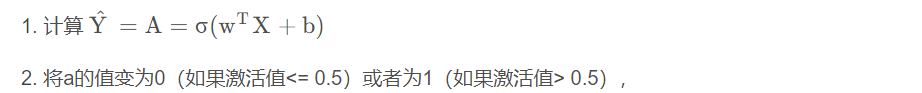

In [23]:
def predict(w, b, X):
    """
    使用学习逻辑回归参数logistic （w，b）预测标签是0还是1，

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数据

    返回：
        Y_prediction  - 包含X中所有图片的所有预测【0 | 1】的一个numpy数组（向量）

    """

    m = X.shape[1]  # 图片的数量
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # 计预测猫在图片中出现的概率
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(A.shape[1]):
        # 将概率a [0，i]转换为实际预测p [0，i]
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    # 使用断言
    assert (Y_prediction.shape == (1, m))

    return Y_prediction

In [24]:
#测试predict
print("====================测试predict====================")
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
print("predictions = " + str(predict(w, b, X)))

====================测试predict====================
predictions = [[1. 1.]]


## 5 - 合并所有函数至model中

In [25]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    通过调用之前实现的函数来构建逻辑回归模型

    参数：
        X_train  - numpy的数组,维度为（num_px * num_px * 3，m_train）的训练集
        Y_train  - numpy的数组,维度为（1，m_train）（矢量）的训练标签集
        X_test   - numpy的数组,维度为（num_px * num_px * 3，m_test）的测试集
        Y_test   - numpy的数组,维度为（1，m_test）的（向量）的测试标签集
        num_iterations  - 表示用于优化参数的迭代次数的超参数
        learning_rate  - 表示optimize（）更新规则中使用的学习速率的超参数
        print_cost  - 设置为true以每100次迭代打印成本

    返回：
        d  - 包含有关模型信息的字典。
    """
    w, b = initialize_with_zeros(X_train.shape[0])

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # 从字典“参数”中检索参数w和b
    w, b = parameters["w"], parameters["b"]

    # 预测测试/训练集的例子
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # 打印训练后的准确性
    print("训练集准确性：", format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100), "%")
    print("测试集准确性：", format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100), "%")

    d = {
        "costs": costs,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediciton_train": Y_prediction_train,
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations}
    return d

In [26]:
print("====================测试model====================")     
#这里加载的是真实的数据，请参见上面的代码部分。
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

====================测试model====================
迭代的次数: 0 ， 误差值： 0.693147
迭代的次数: 100 ， 误差值： 0.584508
迭代的次数: 200 ， 误差值： 0.466949
迭代的次数: 300 ， 误差值： 0.376007
迭代的次数: 400 ， 误差值： 0.331463
迭代的次数: 500 ， 误差值： 0.303273
迭代的次数: 600 ， 误差值： 0.279880
迭代的次数: 700 ， 误差值： 0.260042
迭代的次数: 800 ， 误差值： 0.242941
迭代的次数: 900 ， 误差值： 0.228004
迭代的次数: 1000 ， 误差值： 0.214820
迭代的次数: 1100 ， 误差值： 0.203078
迭代的次数: 1200 ， 误差值： 0.192544
迭代的次数: 1300 ， 误差值： 0.183033
迭代的次数: 1400 ， 误差值： 0.174399
迭代的次数: 1500 ， 误差值： 0.166521
迭代的次数: 1600 ， 误差值： 0.159305
迭代的次数: 1700 ， 误差值： 0.152667
迭代的次数: 1800 ， 误差值： 0.146542
迭代的次数: 1900 ， 误差值： 0.140872
训练集准确性： 99.04306220095694 %
测试集准确性： 70.0 %


绘出成本下降趋势图

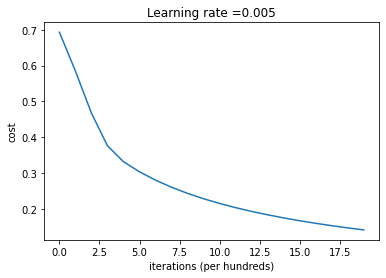

In [27]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

## 6 - 调整学习速率

learning rate is: 0.01
训练集准确性： 99.52153110047847 %
测试集准确性： 68.0 %

-------------------------------------------------------

learning rate is: 0.001
训练集准确性： 88.99521531100478 %
测试集准确性： 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
训练集准确性： 68.42105263157895 %
测试集准确性： 36.0 %

-------------------------------------------------------



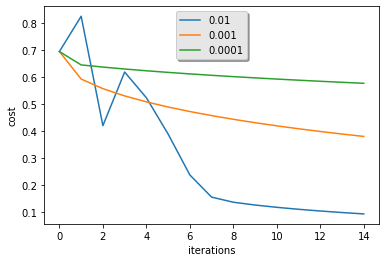

In [28]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

## 7 - 完整代码

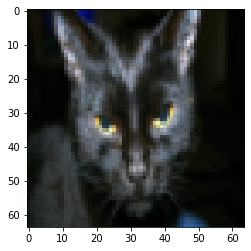

train_set_y=[[0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0
  0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1
  1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0
  1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1
  0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]]
y=[1], it's a cat' picture
训练集的数量: m_train = 209
测试集的数量 : m_test = 50
每张图片的宽/高 : num_px = 64
每张图片的大小 : (64, 64, 3)
训练集_图片的维数 : (209, 64, 64, 3)
训练集_标签的维数 : (1, 209)
测试集_图片的维数: (50, 64, 64, 3)
测试集_标签的维数: (1, 50)
训练集降维最后的维度： (12288, 209)
训练集_标签的维数 : (1, 209)
测试集降维之后的维度: (12288, 50)
测试集_标签的维数 : (1, 50)
====================测试model====================
迭代的次数: 0 ， 误差值： 0.693147
迭代的次数: 100 ， 误差值： 0.584508
迭代的次数: 200 ， 误差值： 0.466949
迭代的次数: 300 ， 误差值： 0.376007
迭代的次数: 400 ， 误差值： 0.331463
迭代的次数: 500 ， 误差值： 0.303273
迭代的次数: 600 ， 误差值： 0.279880
迭代的次数: 700 ， 误差值： 0.

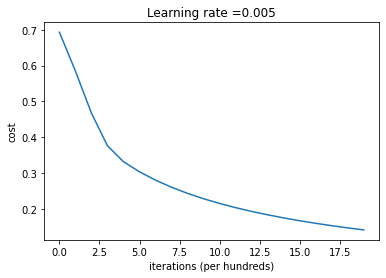

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from lr_utils import load_dataset

train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = load_dataset()

index = 25
plt.imshow(train_set_x_orig[index])
plt.show()
print("train_set_y=" + str(train_set_y)) #你也可以看一下训练集里面的标签是什么样的。

#打印出当前的训练标签值
#使用np.squeeze的目的是压缩维度，【未压缩】train_set_y[:,index]的值为[1] , 【压缩后】np.squeeze(train_set_y[:,index])的值为1
#print("【使用np.squeeze：" + str(np.squeeze(train_set_y[:,index])) + "，不使用np.squeeze： " + str(train_set_y[:,index]) + "】")
#只有压缩后的值才能进行解码操作
print("y=" + str(train_set_y[:,index]) + ", it's a " + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") + "' picture")

m_train = train_set_y.shape[1] #训练集里图片的数量。
m_test = test_set_y.shape[1] #测试集里图片的数量。
num_px = train_set_x_orig.shape[1] #训练、测试集里面的图片的宽度和高度（均为64x64）。

#现在看一看我们加载的东西的具体情况
print ("训练集的数量: m_train = " + str(m_train))
print ("测试集的数量 : m_test = " + str(m_test))
print ("每张图片的宽/高 : num_px = " + str(num_px))
print ("每张图片的大小 : (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("训练集_图片的维数 : " + str(train_set_x_orig.shape))
print ("训练集_标签的维数 : " + str(train_set_y.shape))
print ("测试集_图片的维数: " + str(test_set_x_orig.shape))
print ("测试集_标签的维数: " + str(test_set_y.shape))

#X_flatten = X.reshape(X.shape [0]，-1).T ＃X.T是X的转置
#将训练集的维度降低并转置。
train_set_x_flatten  = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
#将测试集的维度降低并转置。
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("训练集降维最后的维度： " + str(train_set_x_flatten.shape))
print ("训练集_标签的维数 : " + str(train_set_y.shape))
print ("测试集降维之后的维度: " + str(test_set_x_flatten.shape))
print ("测试集_标签的维数 : " + str(test_set_y.shape))

train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255


def sigmoid(z):
    """
    参数：
        z  - 任何大小的标量或numpy数组。

    返回：
        s  -  sigmoid（z）
    """
    s = 1 / (1 + np.exp(-z))
    return s


def initialize_with_zeros(dim):
    """
        此函数为w创建一个维度为（dim，1）的0向量，并将b初始化为0。

        参数：
            dim  - 我们想要的w矢量的大小（或者这种情况下的参数数量）

        返回：
            w  - 维度为（dim，1）的初始化向量。
            b  - 初始化的标量（对应于偏差）
    """
    w = np.zeros(shape=(dim, 1))
    b = 0
    # 使用断言来确保我要的数据是正确的
    assert (w.shape == (dim, 1))  # w的维度是(dim,1)
    assert (isinstance(b, float) or isinstance(b, int))  # b的类型是float或者是int

    return (w, b)


def propagate(w, b, X, Y):
    """
    实现前向和后向传播的成本函数及其梯度。
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 矩阵类型为（num_px * num_px * 3，训练数量）
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据数量)

    返回：
        cost- 逻辑回归的负对数似然成本
        dw  - 相对于w的损失梯度，因此与w相同的形状
        db  - 相对于b的损失梯度，因此与b的形状相同
    """
    m = X.shape[1]

    # 正向传播
    A = sigmoid(np.dot(w.T, X) + b)  # 计算激活值，请参考公式2。
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # 计算成本，请参考公式3和4。

    # 反向传播
    dw = (1 / m) * np.dot(X, (A - Y).T)  # 请参考视频中的偏导公式。
    db = (1 / m) * np.sum(A - Y)  # 请参考视频中的偏导公式。

    # 使用断言确保我的数据是正确的
    assert (dw.shape == w.shape)
    assert (db.dtype == float)
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    # 创建一个字典，把dw和db保存起来。
    grads = {
        "dw": dw,
        "db": db
    }
    return (grads, cost)


def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    此函数通过运行梯度下降算法来优化w和b

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数组。
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据的数量)
        num_iterations  - 优化循环的迭代次数
        learning_rate  - 梯度下降更新规则的学习率
        print_cost  - 每100步打印一次损失值

    返回：
        params  - 包含权重w和偏差b的字典
        grads  - 包含权重和偏差相对于成本函数的梯度的字典
        成本 - 优化期间计算的所有成本列表，将用于绘制学习曲线。

    提示：
    我们需要写下两个步骤并遍历它们：
        1）计算当前参数的成本和梯度，使用propagate（）。
        2）使用w和b的梯度下降法则更新参数。
    """

    costs = []

    for i in range(num_iterations):

        grads, cost = propagate(w, b, X, Y)

        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw
        b = b - learning_rate * db

        # 记录成本
        if i % 100 == 0:
            costs.append(cost)
        # 打印成本数据
        if (print_cost) and (i % 100 == 0):
            print("迭代的次数: %i ， 误差值： %f" % (i, cost))

    params = {
        "w": w,
        "b": b}
    grads = {
        "dw": dw,
        "db": db}
    return (params, grads, costs)


def predict(w, b, X):
    """
    使用学习逻辑回归参数logistic （w，b）预测标签是0还是1，

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数据

    返回：
        Y_prediction  - 包含X中所有图片的所有预测【0 | 1】的一个numpy数组（向量）

    """

    m = X.shape[1]  # 图片的数量
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # 计预测猫在图片中出现的概率
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(A.shape[1]):
        # 将概率a [0，i]转换为实际预测p [0，i]
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    # 使用断言
    assert (Y_prediction.shape == (1, m))

    return Y_prediction


def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    通过调用之前实现的函数来构建逻辑回归模型

    参数：
        X_train  - numpy的数组,维度为（num_px * num_px * 3，m_train）的训练集
        Y_train  - numpy的数组,维度为（1，m_train）（矢量）的训练标签集
        X_test   - numpy的数组,维度为（num_px * num_px * 3，m_test）的测试集
        Y_test   - numpy的数组,维度为（1，m_test）的（向量）的测试标签集
        num_iterations  - 表示用于优化参数的迭代次数的超参数
        learning_rate  - 表示optimize（）更新规则中使用的学习速率的超参数
        print_cost  - 设置为true以每100次迭代打印成本

    返回：
        d  - 包含有关模型信息的字典。
    """
    w, b = initialize_with_zeros(X_train.shape[0])

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # 从字典“参数”中检索参数w和b
    w, b = parameters["w"], parameters["b"]

    # 预测测试/训练集的例子
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # 打印训练后的准确性
    print("训练集准确性：", format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100), "%")
    print("测试集准确性：", format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100), "%")

    d = {
        "costs": costs,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediciton_train": Y_prediction_train,
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations}
    return d

print("====================测试model====================")
#这里加载的是真实的数据，请参见上面的代码部分。
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

#绘制图
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()